Time stepping: 100%|████████████████████████| 1080/1080 [00:12<00:00, 83.25it/s]


Price at (x=100, y=100) = 9695.8296


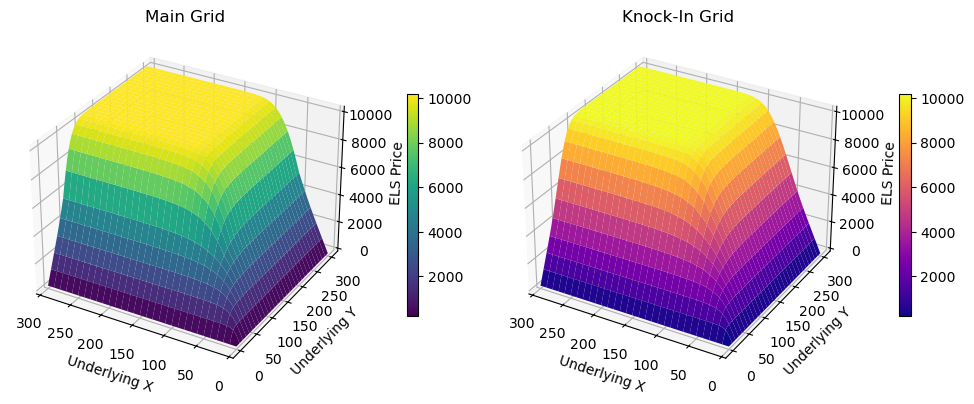

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

def thomas_solver(lower_diag, main_diag, upper_diag, rhs):
    """
    Solve Ax = rhs using the Thomas algorithm (tridiagonal matrix).
    lower_diag: lower diagonal (length n)
    main_diag : main diagonal (length n)
    upper_diag: upper diagonal (length n)
    rhs       : right-hand side vector (length n)
    """
    n = len(rhs)
    x = np.zeros(n, dtype=float)

    # Create working copies
    a = lower_diag.copy()
    b = main_diag.copy()
    c = upper_diag.copy()
    f = rhs.copy()

    # (1) Forward Elimination
    for i in range(1, n):
        m = a[i] / b[i - 1]
        b[i] -= m * c[i - 1]
        f[i] -= m * f[i - 1]

    # (2) Back Substitution
    x[n - 1] = f[n - 1] / b[n - 1]
    for i in range(n - 2, -1, -1):
        x[i] = (f[i] - c[i] * x[i + 1]) / b[i]

    return x


def update_in_x_direction(old_grid, new_grid,
                          nx, ny, dt, h,
                          x_values, y_values,
                          sigma_x, sigma_y, r, rho,
                          cross_coef_x):
    """
    ADI Step 1: Implicit in the x-direction.
    (Fix j, solve tridiagonal system in the i-direction)

    Parameters
    ----------
    cross_coef_x : 1D array of length (nx-2), i.e., 0.5*rho*sigma_x*sigma_y*x_values[1:nx-1]
                  (passed in to avoid recomputing each time)
    """
    # Coefficients for the tridiagonal system in the range i=1..nx-2
    lower_x = -0.5 * (sigma_x * x_values[1:nx-1] / h)**2 + 0.5 * r * (x_values[1:nx-1] / h)
    diag_x  = 1.0/dt + (sigma_x * x_values[1:nx-1] / h)**2 + 0.5 * r
    upper_x = -0.5 * (sigma_x * x_values[1:nx-1] / h)**2 - 0.5 * r * (x_values[1:nx-1] / h)

    # Adjust the last coefficients (original method)
    lower_x[-1] -= upper_x[-1]
    diag_x[-1]  += 2 * upper_x[-1]

    rhs_x = np.zeros(nx - 2, dtype=float)

    # Loop over j for the line solves
    for j in range(1, ny - 1):
        # Compute the right-hand side (rhs): implicit terms
        rhs_x[:] = old_grid[1:nx - 1, j] / dt

        # Cross-derivative term (handled with vector operations)
        # cross_coef = 0.5 * rho * sigma_x * sigma_y * x_values[i] * y_values[j]
        #            = cross_coef_x[i-1] * y_values[j]
        cross_term = (
            old_grid[2:nx, j + 1] - old_grid[2:nx, j - 1]
            - old_grid[0:nx - 2, j + 1] + old_grid[0:nx - 2, j - 1]
        ) / (4.0 * h * h)

        # Broadcast multiply by cross_coef_x * y_values[j]
        rhs_x += cross_coef_x * y_values[j] * cross_term

        # Solve with Thomas algorithm
        sol_slice = thomas_solver(lower_x, diag_x, upper_x, rhs_x)
        new_grid[1:nx - 1, j] = sol_slice

        # Update boundaries immediately (original method)
        new_grid[nx - 1, 1:ny - 1] = 2 * new_grid[nx - 2, 1:ny - 1] - new_grid[nx - 3, 1:ny - 1]
        new_grid[:, ny - 1] = 2 * new_grid[:, ny - 2] - new_grid[:, ny - 3]


def update_in_y_direction(old_grid, new_grid,
                          nx, ny, dt, h,
                          x_values, y_values,
                          sigma_x, sigma_y, r, rho,
                          cross_coef_y):
    """
    ADI Step 2: Implicit in the y-direction.
    (Fix i, solve tridiagonal system in the j-direction)

    Parameters
    ----------
    cross_coef_y : 1D array of length (ny-2), i.e., 0.5*rho*sigma_x*sigma_y*y_values[1:ny-1]
                  (passed in to avoid recomputing each time)
    """
    lower_y = -0.5 * (sigma_y * y_values[1:ny - 1] / h)**2 + 0.5 * r * (y_values[1:ny - 1] / h)
    diag_y  = 1.0/dt + (sigma_y * y_values[1:ny - 1] / h)**2 + 0.5 * r
    upper_y = -0.5 * (sigma_y * y_values[1:ny - 1] / h)**2 - 0.5 * r * (y_values[1:ny - 1] / h)

    lower_y[-1] -= upper_y[-1]
    diag_y[-1]  += 2 * upper_y[-1]

    rhs_y = np.zeros(ny - 2, dtype=float)

    # Loop over i for the line solves
    for i in range(1, nx - 1):
        # Compute the right-hand side (rhs)
        rhs_y[:] = old_grid[i, 1:ny - 1] / dt

        # Cross-derivative term (vector operations)
        # cross_coef = 0.5 * rho * sigma_x * sigma_y * x_values[i] * y_values[j]
        #            = cross_coef_y[j-1] * x_values[i]
        cross_term = (
            old_grid[i + 1, 2:ny] - old_grid[i + 1, 0:ny - 2]
            - old_grid[i - 1, 2:ny] + old_grid[i - 1, 0:ny - 2]
        ) / (4.0 * h * h)

        rhs_y += cross_coef_y * x_values[i] * cross_term

        # Solve with Thomas algorithm
        sol_slice = thomas_solver(lower_y, diag_y, upper_y, rhs_y)
        new_grid[i, 1:ny - 1] = sol_slice

        # Update boundaries immediately
        new_grid[1:nx - 1, ny - 1] = 2 * new_grid[1:nx - 1, ny - 2] - new_grid[1:nx - 1, ny - 3]
        new_grid[nx - 1, :] = 2 * new_grid[nx - 2, :] - new_grid[nx - 3, :]


def main_els_pricing_fast():
    # ----------------------
    # 1) Parameter Setup
    # ----------------------
    FACE_VALUE = 10000
    R = 300
    SIGMA_X = 0.249
    SIGMA_Y = 0.2182
    RHO = 0.0981
    RISK_FREE = 0.0165

    num_x = 61
    num_y = num_x
    x_points = np.linspace(0, R, num_x)
    y_points = np.linspace(0, R, num_y)
    h = R / num_x  # Define h as R / num_x as in the original

    T = 3
    Nt = 360 * T   # 1080 steps
    dt = T / Nt

    # Coupon rates and event steps (early redemption points)
    coupon_rate = np.array([0.15, 0.125, 0.10, 0.075, 0.05, 0.025])
    step_events = np.array([
        int(round(Nt/6)),
        int(round(2*Nt/6)),
        int(round(3*Nt/6)),
        int(round(4*Nt/6)),
        int(round(5*Nt/6)),
        Nt + 1
    ])

    # Initial condition parameters
    strike_array = np.array([0.75, 0.80, 0.85, 0.85, 0.90, 0.90])
    dummy_coupon = 0.15
    KIB = 0.50

    # ----------------------
    # 2) Grid Preparation
    # ----------------------
    main_grid = np.zeros((num_x, num_y))
    knock_grid = np.zeros((num_x, num_y))

    X0 = 100
    Y0 = 100

    # (A) Set payoff at maturity (or first step)
    for i in range(num_x):
        for j in range(num_y):
            if (x_points[i] < KIB * X0) or (y_points[j] < KIB * Y0):
                payoff_val = min(x_points[i], y_points[j]) / X0 * FACE_VALUE
                main_grid[i, j] = payoff_val
                knock_grid[i, j] = payoff_val
            elif (x_points[i] <= strike_array[0] * X0) or (y_points[j] <= strike_array[0] * Y0):
                main_grid[i, j] = FACE_VALUE * (1 + dummy_coupon)
                knock_grid[i, j] = min(x_points[i], y_points[j]) / X0 * FACE_VALUE
            else:
                main_grid[i, j] = FACE_VALUE * (1 + coupon_rate[0])
                knock_grid[i, j] = FACE_VALUE * (1 + coupon_rate[0])

    # Precompute 1D arrays for cross coefficients (for vectorization)
    # cross_coef_x[i] = 0.5 * RHO * SIGMA_X * SIGMA_Y * x_points[i+1], for i=0..(nx-2)
    cross_coef_x = 0.5 * RHO * SIGMA_X * SIGMA_Y * x_points[1:num_x - 1]
    cross_coef_y = 0.5 * RHO * SIGMA_X * SIGMA_Y * y_points[1:num_y - 1]

    # ----------------------
    # 3) Time Stepping (ADI)
    # ----------------------
    tag = 0

    # Precompute boundary indices for each early redemption period (vectorized)
    boundary_indices_x = np.searchsorted(x_points, X0 * strike_array)
    boundary_indices_y = np.searchsorted(y_points, Y0 * strike_array)

    boundary_kib_x = np.searchsorted(x_points, X0 * KIB)
    boundary_kib_y = np.searchsorted(y_points, Y0 * KIB)

    for n in tqdm(range(Nt), desc="Time stepping"):
        # (a) Check for event (early redemption point)
        if n == step_events[tag]:
            if tag < len(coupon_rate) - 1:
                bx = boundary_indices_x[tag+1]
                by = boundary_indices_y[tag+1]
                # Set values in the early redemption exercise region
                main_grid[bx:, by:] = FACE_VALUE * (1 + coupon_rate[tag+1])
                knock_grid[bx:, by:] = FACE_VALUE * (1 + coupon_rate[tag+1])
            tag += 1

        # (b) Apply Knock-In Barrier
        # Use knock_grid values in the lower/left regions where knock-in occurs
        main_grid[:boundary_kib_x+1, :] = knock_grid[:boundary_kib_x+1, :]
        main_grid[:, :boundary_kib_y+1] = knock_grid[:, :boundary_kib_y+1]

        # (c) ADI Step: main_grid
        old_main = main_grid.copy()
        update_in_x_direction(old_main, main_grid,
                              num_x, num_y, dt, h,
                              x_points, y_points,
                              SIGMA_X, SIGMA_Y, RISK_FREE, RHO,
                              cross_coef_x)
        old_main = main_grid.copy()
        update_in_y_direction(old_main, main_grid,
                              num_x, num_y, dt, h,
                              x_points, y_points,
                              SIGMA_X, SIGMA_Y, RISK_FREE, RHO,
                              cross_coef_y)

        # (d) ADI Step: knock_grid
        old_knock = knock_grid.copy()
        update_in_x_direction(old_knock, knock_grid,
                              num_x, num_y, dt, h,
                              x_points, y_points,
                              SIGMA_X, SIGMA_Y, RISK_FREE, RHO,
                              cross_coef_x)
        old_knock = knock_grid.copy()
        update_in_y_direction(old_knock, knock_grid,
                              num_x, num_y, dt, h,
                              x_points, y_points,
                              SIGMA_X, SIGMA_Y, RISK_FREE, RHO,
                              cross_coef_y)

    # ----------------------
    # 4) Visualization + Numerical Output
    # ----------------------
    X_mesh, Y_mesh = np.meshgrid(x_points, y_points, indexing='ij')

    fig = plt.figure(figsize=(10, 4))

    # (Left) main_grid plot
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    surf1 = ax1.plot_surface(X_mesh, Y_mesh, main_grid, cmap='viridis', edgecolor='none')
    ax1.set_xlabel("Underlying X")
    ax1.set_ylabel("Underlying Y")
    ax1.set_zlabel("ELS Price")
    ax1.set_title("Main Grid")
    fig.colorbar(surf1, ax=ax1, shrink=0.6, pad=0.1)

    # Reverse x-axis range
    ax1.set_xlim([x_points[-1], x_points[0]])  # or ax1.invert_xaxis()

    # (Right) knock_grid plot
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    surf2 = ax2.plot_surface(X_mesh, Y_mesh, knock_grid, cmap='plasma', edgecolor='none')
    ax2.set_xlabel("Underlying X")
    ax2.set_ylabel("Underlying Y")
    ax2.set_zlabel("ELS Price")
    ax2.set_title("Knock-In Grid")
    fig.colorbar(surf2, ax=ax2, shrink=0.6, pad=0.1)

    # Reverse x-axis range
    ax2.set_xlim([x_points[-1], x_points[0]])  # or ax2.invert_xaxis()

    # Check value at specific point (x=100, y=100)
    idx_x = np.searchsorted(x_points, 100)
    idx_y = np.searchsorted(y_points, 100)
    price_100_100 = main_grid[idx_x, idx_y]
    print("Price at (x=100, y=100) = {:.4f}".format(price_100_100))

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main_els_pricing_fast()